<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/TRANSFERLEARNIG_CROSSTEST_CAMPANELLA_CNN_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal
import os

In [ ]:
def parse_numeric_value(x):
    """Pulisce una stringa con più punti nel numero, mantenendo solo il primo come separatore decimale."""
    try:
        if isinstance(x, str):
            x = x.strip().replace(' ', '')  # Rimuove spazi
            if x.count('.') > 1:
                parts = x.split('.')
                return float(parts[0] + '.' + ''.join(parts[1:]))
            return float(x)
        return float(x)
    except:
        return np.nan

In [ ]:
def load_empatica_subjects_data(base_path, target_freq=64):
    """
    Carica, pulisce e normalizza i segnali da cartelle Empatica in un unico DataFrame.
    """
    freq_map = {
        'ACC': 32,
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4
    }

    signal_files = ['ACC.csv', 'BVP.csv', 'EDA.csv', 'TEMP.csv']
    subjects = sorted([d for d in os.listdir(base_path) if d.startswith("subject_")])
    all_data = []

    for subject in subjects:
        subject_path = os.path.join(base_path, subject)
        signals = {}

        for signal_name in signal_files:
            file_path = os.path.join(subject_path, signal_name)
            try:
                # Caricamento file, parsing numerico sicuro su ogni colonna
                raw_data = pd.read_csv(file_path, header=None)
                for col in raw_data.columns:
                    raw_data[col] = raw_data[col].map(parse_numeric_value)

                # Frequenza originale
                orig_freq = freq_map[signal_name.split('.')[0]]
                n_samples = int(len(raw_data) * target_freq / orig_freq)

                # Resample
                resampled = resample(raw_data.values, n_samples, axis=0)

                if signal_name == 'ACC.csv':
                    signals['acc1'] = resampled[:, 0]
                    signals['acc2'] = resampled[:, 1]
                    signals['acc3'] = resampled[:, 2]
                else:
                    key = signal_name.split('.')[0].lower()
                    signals[key] = resampled.squeeze()

            except Exception as e:
                print(f"Errore caricando {file_path}: {e}")
                continue

        # Allineamento lunghezze
        min_len = min(len(sig) for sig in signals.values())
        for k in signals:
            signals[k] = signals[k][:min_len]

        df_subject = pd.DataFrame(signals)
        df_subject['subject'] = subject
        all_data.append(df_subject)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
df = load_empatica_subjects_data('/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/Subjects')
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject
0,-11.000000,-42.000000,47.000000,-5.081451e-15,6.160874e-15,32.680000,subject_01
1,-3.731070,-48.832680,53.868799,-5.371820e-14,-2.176869e-01,32.693612,subject_01
2,-12.000000,-42.000000,48.000000,-5.081451e-15,-3.885328e-01,32.704953,subject_01
3,-17.019673,-38.224616,44.537763,-2.499893e-14,-5.120843e-01,32.713979,subject_01
4,-13.000000,-42.000000,48.000000,2.958131e-14,-5.889338e-01,32.720702,subject_01


In [ ]:
def assign_labels_to_dataset(df, fs=64):
    """
    Etichetta ogni record del dataset seguendo il protocollo degli autori:
    - Primi 27 minuti: pattern misto stress/rest
    - Dal 28° minuto a -5 dalla fine: stress continuo
    - Ultimi 5 minuti: pattern fisso [0, 0, 1, 0, 0]

    Restituisce il DataFrame con una colonna 'label' assegnata.
    """
    samples_per_minute = fs * 60
    labeled_data = []

    for subject in df['subject'].unique():
        df_subj = df[df['subject'] == subject].reset_index(drop=True)
        total_samples = len(df_subj)

        # Indici di separazione
        first_end = 27 * samples_per_minute
        last_start = total_samples - 5 * samples_per_minute

        labels = np.ones(total_samples, dtype=int)  # default: stress

        # Etichettatura primi 27 minuti
        first_labels = np.ones(27, dtype=int)
        rest_minutes = [0, 1, 2, 13, 14, 20, 21, 25, 26]
        for idx in rest_minutes:
            if idx < len(first_labels):
                first_labels[idx] = 0

        for i, label in enumerate(first_labels):
            start = i * samples_per_minute
            end = min((i + 1) * samples_per_minute, total_samples)
            labels[start:end] = label

        # Etichettatura ultimi 5 minuti con pattern fisso
        final_pattern = [0, 0, 1, 0, 0]
        for i, label in enumerate(final_pattern):
            start = last_start + i * samples_per_minute
            end = min(start + samples_per_minute, total_samples)
            if start < total_samples:
                labels[start:end] = label

        df_subj['label'] = labels
        labeled_data.append(df_subj)

    return pd.concat(labeled_data, ignore_index=True)

In [ ]:
df = assign_labels_to_dataset(df)
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject,label
0,-11.000000,-42.000000,47.000000,-5.081451e-15,6.160874e-15,32.680000,subject_01,0
1,-3.731070,-48.832680,53.868799,-5.371820e-14,-2.176869e-01,32.693612,subject_01,0
2,-12.000000,-42.000000,48.000000,-5.081451e-15,-3.885328e-01,32.704953,subject_01,0
3,-17.019673,-38.224616,44.537763,-2.499893e-14,-5.120843e-01,32.713979,subject_01,0
4,-13.000000,-42.000000,48.000000,2.958131e-14,-5.889338e-01,32.720702,subject_01,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149992 entries, 0 to 4149991
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   subject  object 
 7   label    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 253.3+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp,label
count,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06
mean,-3.535236e+01,-3.736105e+00,3.941349e+01,-2.878704e-04,1.288284e+00,3.072690e+01,6.511608e-01
std,2.346571e+01,1.922544e+01,2.465455e+01,1.064747e+02,1.666268e+00,2.317582e+00,4.766031e-01
min,-1.639683e+02,-1.454716e+02,-1.553384e+02,-2.028660e+03,-1.395154e+00,2.547305e+01,0.000000e+00
25%,-5.373538e+01,-1.230737e+01,2.692636e+01,-2.882000e+01,3.130024e-01,2.923413e+01,0.000000e+00
50%,-3.768750e+01,-2.910135e+00,4.700000e+01,1.810000e+00,6.492752e-01,3.098952e+01,1.000000e+00
75%,-2.209895e+01,6.000000e+00,5.865897e+01,3.030000e+01,1.660052e+00,3.275977e+01,1.000000e+00
max,1.646671e+02,1.324840e+02,1.695915e+02,2.627920e+03,1.319185e+01,3.447453e+01,1.000000e+00


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2 + df['acc2']**2 + df['acc3']**2)
df = df.drop(columns=['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
freq_assolute = df['label'].value_counts()
freq_relative = df['label'].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolute Frequency': freq_assolute,
    'Relative Frequency': freq_relative.round(2)*100
})

frequency_table

,Absolute Frequency,Relative Frequency
label,,
1,2702312,65.0
0,1447680,35.0


In [ ]:
df.isna().sum()

,0
bvp,0
eda,0
temp,0
subject,0
label,0
acc_mag,0


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.2 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp'] = ppg_clean

In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_mag'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp'] = temp_denoise(df['temp'].values, fs)

In [ ]:
df['subject'].value_counts()

,count
subject,
subject_26,169856
subject_14,165888
subject_01,160256
subject_28,160000
subject_25,160000
subject_17,153472
subject_02,150720
subject_29,149120
subject_15,145920


In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.7):
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # Condizione: label dominante deve essere almeno il 70%
            if dominant_ratio >= threshold:
                X.append(window)
                y.append(dominant_label)
                groups.append(subject_id)

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['bvp', 'eda', 'acc_mag', 'temp']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.7
    )

    if segnale == segnali[0]:
        y = y_raw  # le label sono già 0/1, non serve sottrarre 1
        group_labels = groups
    X_dict[segnale] = X

Processing bvp...
Processing eda...
Processing acc_mag...
Processing temp...


In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione bvp: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione eda: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione acc_mag: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione temp: (5197, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (5197,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1678, 3519]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

bvp: float32
eda: float32
acc_mag: float32
temp: float32


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Concatenate, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.activations import sigmoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Add, Multiply, Reshape, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import joblib
import json

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=0.001,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

WESAD --> CAMPANELLA

CROSS TEST WESAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9910
Soggetto migliore: S8

CROSS TEST: WESAD MODEL → CAMPANELLA DATASET
Inizio valutazione cross-test...
  Fold  1 - subject_01: F1=0.834 Acc=0.716
  Fold  2 - subject_02: F1=0.235 Acc=0.344
  Fold  3 - subject_03: F1=0.795 Acc=0.711
  Fold  4 - subject_04: F1=0.045 Acc=0.234
  Fold  5 - subject_05: F1=0.281 Acc=0.446
  Fold  6 - subject_06: F1=0.751 Acc=0.634
  Fold  7 - subject_07: F1=0.583 Acc=0.576
  Fold  8 - subject_08: F1=0.376 Acc=0.362
  Fold  9 - subject_09: F1=0.442 Acc=0.514
  Fold 10 - subject_10: F1=0.542 Acc=0.500
  Fold 11 - subject_11: F1=0.478 Acc=0.440
  Fold 12 - subject_12: F1=0.826 Acc=0.719
  Fold 13 - subject_13: F1=0.838 Acc=0.743
  Fold 14 - subject_14: F1=0.834 Acc=0.738
  Fold 15 - subject_15: F1=0.576 Acc=0.576
  Fold 16 - subject_16: F1=0.463 Acc=0.530
  Fold 17 - subject_17: F1=0.836 Acc=0.732
  Fold 18 - subject_18: F1=0.568 Acc=0.527
  Fold 19 - subject_19: F1=0.802 Acc=0.692
  Fold 20 - subject_20: F1=0.6

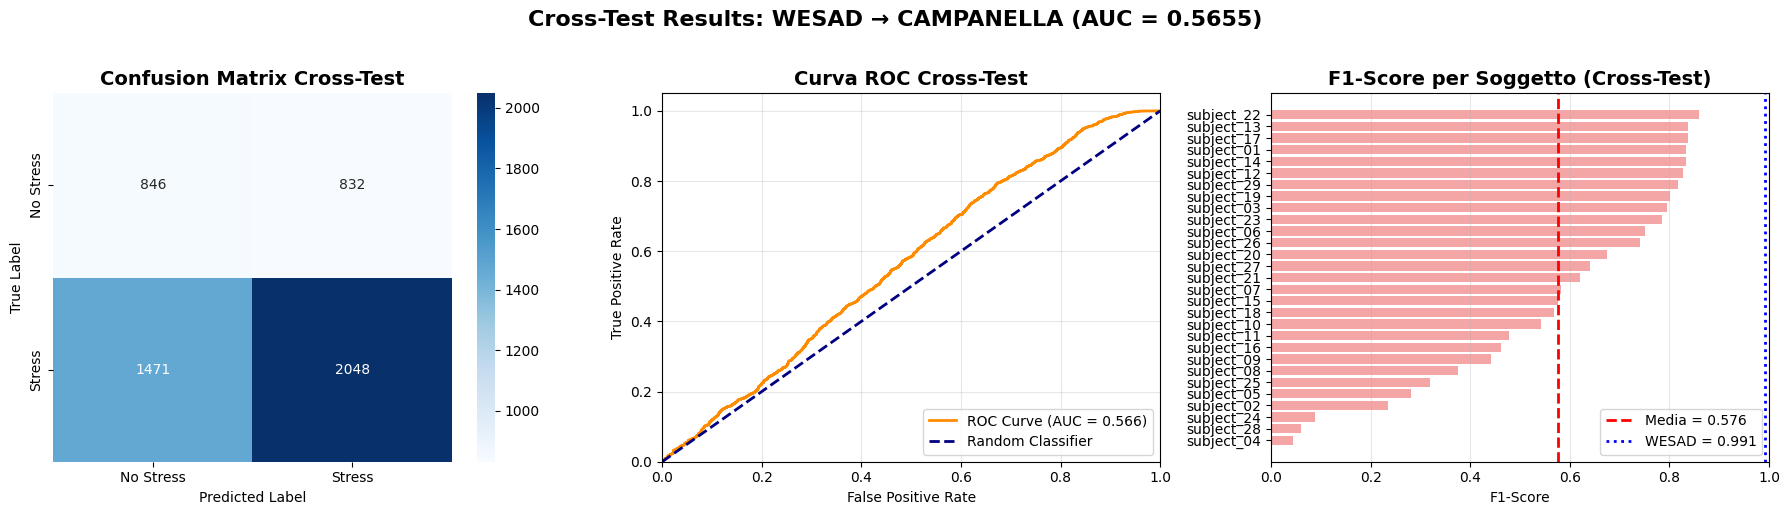


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_campanella_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_campanella_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: WESAD MODEL SU CAMPANELLA CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
wesad_model, wesad_scalers, wesad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: WESAD MODEL → CAMPANELLA DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (Campanella)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler WESAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler WESAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = wesad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello WESAD
    try:
        y_pred_proba = wesad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello WESAD
        threshold = wesad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale WESAD:")
    print(f"F1 WESAD:     {wesad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - wesad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC




    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance WESAD originale
        axes[2].axvline(x=wesad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {wesad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: WESAD → CAMPANELLA (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "wesad_to_campanella_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(wesad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(wesad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "wesad_to_campanella_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARING WESAD CNN

✓ Modello WESAD.keras caricato
✓ Scalers WESAD caricati
=== WESAD MODEL INFO ===
F1-Score: 0.990990990990991
Best Subject: S8

TRANSFER LEARNING CORRETTO: WESAD → CAMPANELLA
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - subject_01: F1=0.871 (5ep)
  Fold  2 - subject_02: F1=0.803 (6ep)
  Fold  3 - subject_03: F1=0.789 (5ep)
  Fold  4 - subject_04: F1=0.682 (7ep)
  Fold  5 - subject_05: F1=0.749 (6ep)
  Fold  6 - subject_06: F1=0.801 (6ep)
  Fold  7 - subject_07: F1=0.701 (5ep)
  Fold  8 - subject_08: ⚠️COLLAPSE→FIXED→F1=0.142 (6ep)
  Fold  9 - subject_09: F1=0.741 (5ep)
  Fold 10 - subject_10: F1=0.777 (8ep)
  Fold 11 - subject_11: F1=0.829 (8ep)
  Fold 12 - subject_12: F1=0.752 (5ep)
  Fold 13 - subject_13: F1=0.690 (5ep)
  Fold 14 - subject_14: F1=0.803 (5ep)
  Fold 15 - subject_15: F1=0.782 (5ep)
  Fold 16 - subject_16: F1=0.749 (8ep)
  Fold 17 - subject_17: F1=0.855 (5ep)
  Fold 18 - subject_18: F1=0.726 (8ep)
  Fold 19 - subject_19: F1=0.821 (6ep)
  Fold 20 - s

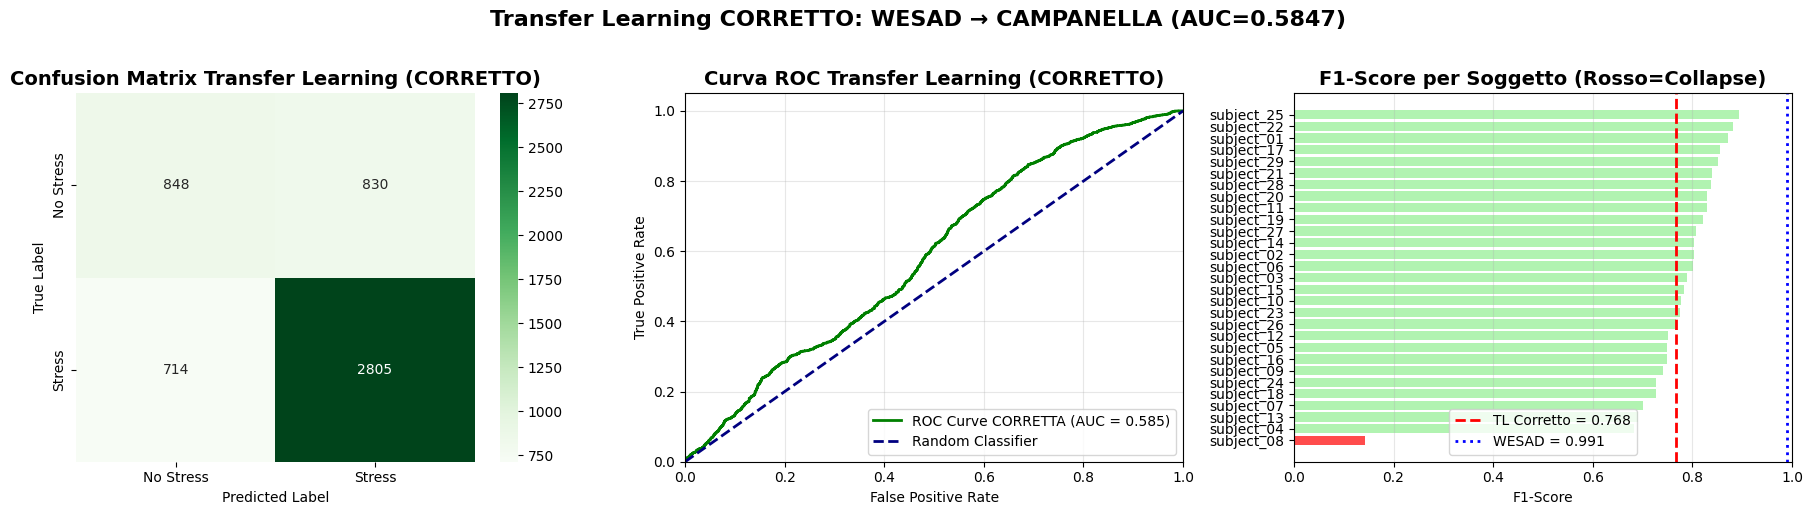


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/WESAD_TO_CAMPANELLA_RESULTS_FIXED/wesad_to_campanella_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/WESAD_TO_CAMPANELLA_RESULTS_FIXED/wesad_to_campanella_corrected_summary.json

TRANSFER LEARNING CORRETTO COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: WESAD → CAMPANELLA CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV WESAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV WESAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="WESAD"):
    """Carica modello sorgente WESAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello WESAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON WESAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello WESAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers WESAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "WESAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: WESAD → CAMPANELLA")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (CAMPANELLA)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/WESAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER WESAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER WESAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler WESAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"WESAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: WESAD → CAMPANELLA (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/WESAD_TO_CAMPANELLA_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "wesad_to_campanella_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'CAMPANELLA',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "wesad_to_campanella_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

VERBIO --> CAMPANELLA

CROSS TEST VERBIO CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9600
Soggetto migliore: P005

CROSS TEST: VERBIO MODEL → CAMPANELLA DATASET
Inizio valutazione cross-test...
  Fold  1 - subject_01: F1=0.104 Acc=0.324
  Fold  2 - subject_02: F1=0.347 Acc=0.344
  Fold  3 - subject_03: F1=0.827 Acc=0.753
  Fold  4 - subject_04: F1=0.833 Acc=0.743
  Fold  5 - subject_05: F1=0.580 Acc=0.590
  Fold  6 - subject_06: F1=0.763 Acc=0.669
  Fold  7 - subject_07: F1=0.830 Acc=0.750
  Fold  8 - subject_08: F1=0.493 Acc=0.384
  Fold  9 - subject_09: F1=0.678 Acc=0.667
  Fold 10 - subject_10: F1=0.652 Acc=0.545
  Fold 11 - subject_11: F1=0.000 Acc=0.345
  Fold 12 - subject_12: F1=0.542 Acc=0.478
  Fold 13 - subject_13: F1=0.787 Acc=0.691
  Fold 14 - subject_14: F1=0.892 Acc=0.838
  Fold 15 - subject_15: F1=0.458 Acc=0.511
  Fold 16 - subject_16: F1=0.716 Acc=0.679
  Fold 17 - subject_17: F1=0.235 Acc=0.361
  Fold 18 - subject_18: F1=0.364 Acc=0.455
  Fold 19 - subject_19: F1=0.794 Acc=0.686
  Fold 20 - subject_20: F1=

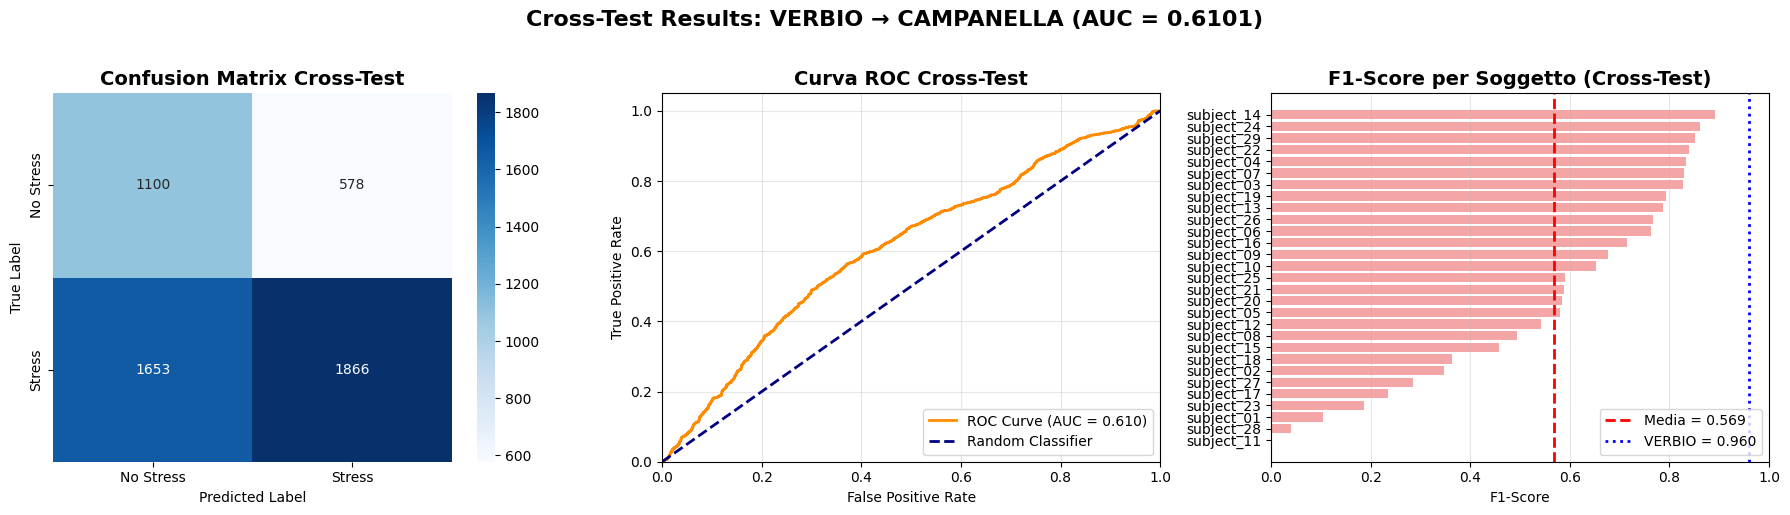


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_campanella_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_campanella_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: VERBIO MODEL SU CAMPANELLA CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
verbio_model, verbio_scalers, verbio_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: VERBIO MODEL → CAMPANELLA DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (Campanella)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler VERBIO
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler VERBIO
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = verbio_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello VERBIO
    try:
        y_pred_proba = verbio_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello VERBIO
        threshold = verbio_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale VERBIO:")
    print(f"F1 VERBIO:     {verbio_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - verbio_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance VERBIO originale
        axes[2].axvline(x=verbio_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {verbio_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: VERBIO → CAMPANELLA (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "verbio_to_campanella_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(verbio_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(verbio_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "verbio_to_campanella_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING VERBIO CNN

✓ Modello VERBIO.keras caricato
✓ Scalers VERBIO caricati
=== VERBIO MODEL INFO ===
F1-Score: 0.96
Best Subject: P005

TRANSFER LEARNING: VERBIO → CAMPANELLA
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - subject_01: F1=0.656 (8ep)
  Fold  2 - subject_02: F1=0.215 (5ep)
  Fold  3 - subject_03: F1=0.820 (5ep)
  Fold  4 - subject_04: F1=0.835 (7ep)
  Fold  5 - subject_05: F1=0.772 (5ep)
  Fold  6 - subject_06: F1=0.765 (5ep)
  Fold  7 - subject_07: F1=0.808 (5ep)
  Fold  8 - subject_08: F1=0.017 (5ep)
  Fold  9 - subject_09: F1=0.798 (5ep)
  Fold 10 - subject_10: F1=0.736 (5ep)
  Fold 11 - subject_11: F1=0.833 (6ep)
  Fold 12 - subject_12: F1=0.758 (7ep)
  Fold 13 - subject_13: F1=0.736 (6ep)
  Fold 14 - subject_14: F1=0.888 (5ep)
  Fold 15 - subject_15: F1=0.941 (5ep)
  Fold 16 - subject_16: F1=0.755 (5ep)
  Fold 17 - subject_17: F1=0.819 (6ep)
  Fold 18 - subject_18: F1=0.814 (6ep)
  Fold 19 - subject_19: F1=0.823 (5ep)
  Fold 20 - subject_20: F1=0.834 (5ep)
  Fold 

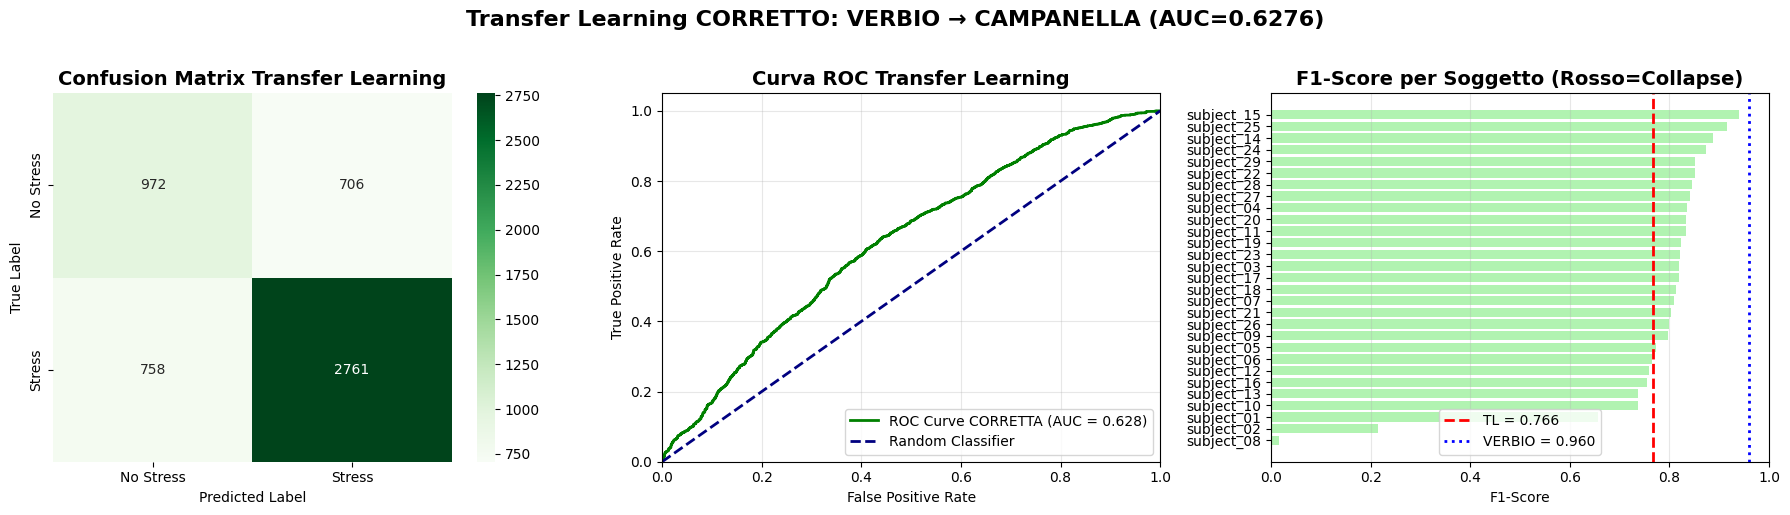


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/VERBIO_TO_CAMPANELLA_RESULTS_FIXED/verbio_to_campanella_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/VERBIO_TO_CAMPANELLA_RESULTS_FIXED/verbio_to_campanella_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: VERBIO → CAMPANELLA CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV VERBIO se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV VERBIO: {e}")
    return None

def load_source_model(model_dir, dataset_name="VERBIO"):
    """Carica modello sorgente VERBIO con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello VERBIO
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON VERBIO corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello VERBIO!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers VERBIO
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "VERBIO")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: VERBIO → CAMPANELLA")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (CAMPANELLA)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/VERBIO_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER VERBIO (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER VERBIO ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler VERBIO
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"VERBIO originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: VERBIO → CAMPANELLA (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/VERBIO_TO_CAMPANELLA_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "verbio_to_campanella_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'CAMPANELLA',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "verbio_to_campanella_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

AFFECTIVE ROAD --> CAMPANELLA





CROSS TEST AFFECTIVE ROAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.8360
Soggetto migliore: Drv3

CROSS TEST: AFFECTIVE ROAD MODEL → CAMPANELLA DATASET
Inizio valutazione cross-test...
  Fold  1 - subject_01: F1=0.383 Acc=0.431
  Fold  2 - subject_02: F1=0.568 Acc=0.492
  Fold  3 - subject_03: F1=0.835 Acc=0.759
  Fold  4 - subject_04: F1=0.756 Acc=0.707
  Fold  5 - subject_05: F1=0.784 Acc=0.747
  Fold  6 - subject_06: F1=0.785 Acc=0.692
  Fold  7 - subject_07: F1=0.607 Acc=0.616
  Fold  8 - subject_08: F1=0.664 Acc=0.542
  Fold  9 - subject_09: F1=0.796 Acc=0.768
  Fold 10 - subject_10: F1=0.762 Acc=0.676
  Fold 11 - subject_11: F1=0.167 Acc=0.405
  Fold 12 - subject_12: F1=0.414 Acc=0.444
  Fold 13 - subject_13: F1=0.733 Acc=0.691
  Fold 14 - subject_14: F1=0.667 Acc=0.610
  Fold 15 - subject_15: F1=0.833 Acc=0.799
  Fold 16 - subject_16: F1=0.316 Acc=0.458
  Fold 17 - subject_17: F1=0.107 Acc=0.314
  Fold 18 - subject_18: F1=0.417 Acc=0.497
  Fold 19 - subject_19: F1=0.854 Acc=0.775
  Fold 20 - subject

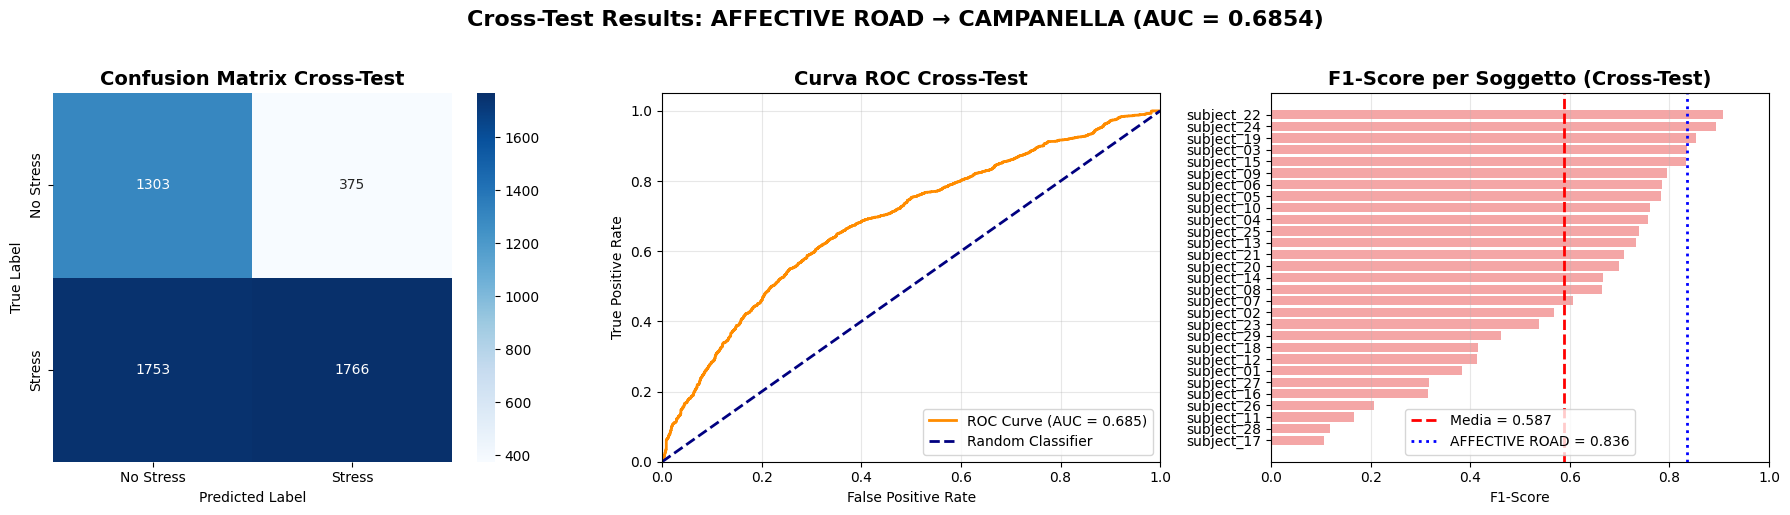


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_campanella_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_campanella_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: AFFECTIVE ROAD MODEL SU CAMPANELLA CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
affectiveroad_model, affectiveroad_scalers, affectiveroad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: AFFECTIVE ROAD MODEL → CAMPANELLA DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (Campanella)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler AFFECTIVE ROAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler AFFECTIVE ROAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = affectiveroad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello AFFECTIVE ROAD
    try:
        y_pred_proba = affectiveroad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello AFFECTIVE ROAD
        threshold = affectiveroad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale AFFECTIVE ROAD:")
    print(f"F1 AFFECTIVE ROAD:     {affectiveroad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - affectiveroad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance AFFECTIVE ROAD originale
        axes[2].axvline(x=affectiveroad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {affectiveroad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: AFFECTIVE ROAD → CAMPANELLA (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "affectiveroad_to_campanella_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(affectiveroad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(affectiveroad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_campanella_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING AFFECTIVE ROAD CNN

✓ Modello AFFECTIVE ROAD.keras caricato
✓ Scalers AFFECTIVE ROAD caricati
=== AFFECTIVE ROAD MODEL INFO ===
F1-Score: 0.8359788359788359
Best Subject: Drv3

TRANSFER LEARNING: AFFECTIVE ROAD → CAMPANELLA
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - subject_01: F1=0.781 (5ep)
  Fold  2 - subject_02: F1=0.299 (5ep)
  Fold  3 - subject_03: 

F1=0.834 (8ep)
  Fold  4 - subject_04: 

F1=0.858 (5ep)
  Fold  5 - subject_05: F1=0.808 (5ep)
  Fold  6 - subject_06: F1=0.788 (5ep)
  Fold  7 - subject_07: F1=0.772 (8ep)
  Fold  8 - subject_08: F1=0.243 (5ep)
  Fold  9 - subject_09: F1=0.823 (5ep)
  Fold 10 - subject_10: F1=0.750 (5ep)
  Fold 11 - subject_11: F1=0.847 (6ep)
  Fold 12 - subject_12: F1=0.748 (5ep)
  Fold 13 - subject_13: F1=0.822 (6ep)
  Fold 14 - subject_14: F1=0.829 (5ep)
  Fold 15 - subject_15: F1=0.921 (6ep)
  Fold 16 - subject_16: F1=0.785 (8ep)
  Fold 17 - subject_17: F1=0.781 (6ep)
  Fold 18 - subject_18: F1=0.701 (7ep)
  Fold 19 - subject_19: F1=0.704 (8ep)
  Fold 20 - subject_20: F1=0.804 (5ep)
  Fold 21 - subject_21: F1=0.820 (5ep)
  Fold 22 - subject_22: F1=0.905 (5ep)
  Fold 23 - subject_23: F1=0.769 (6ep)
  Fold 24 - subject_24: F1=0.907 (5ep)
  Fold 25 - subject_25: F1=0.914 (5ep)
  Fold 26 - subject_26: F1=0.853 (5ep)
  Fold 27 - subject_27: F1=0.859 (5ep)
  Fold 28 - subject_28: F1=0.704 (5ep)
  Fold 29 - subject_29: F1=0.739 (5ep)

---------

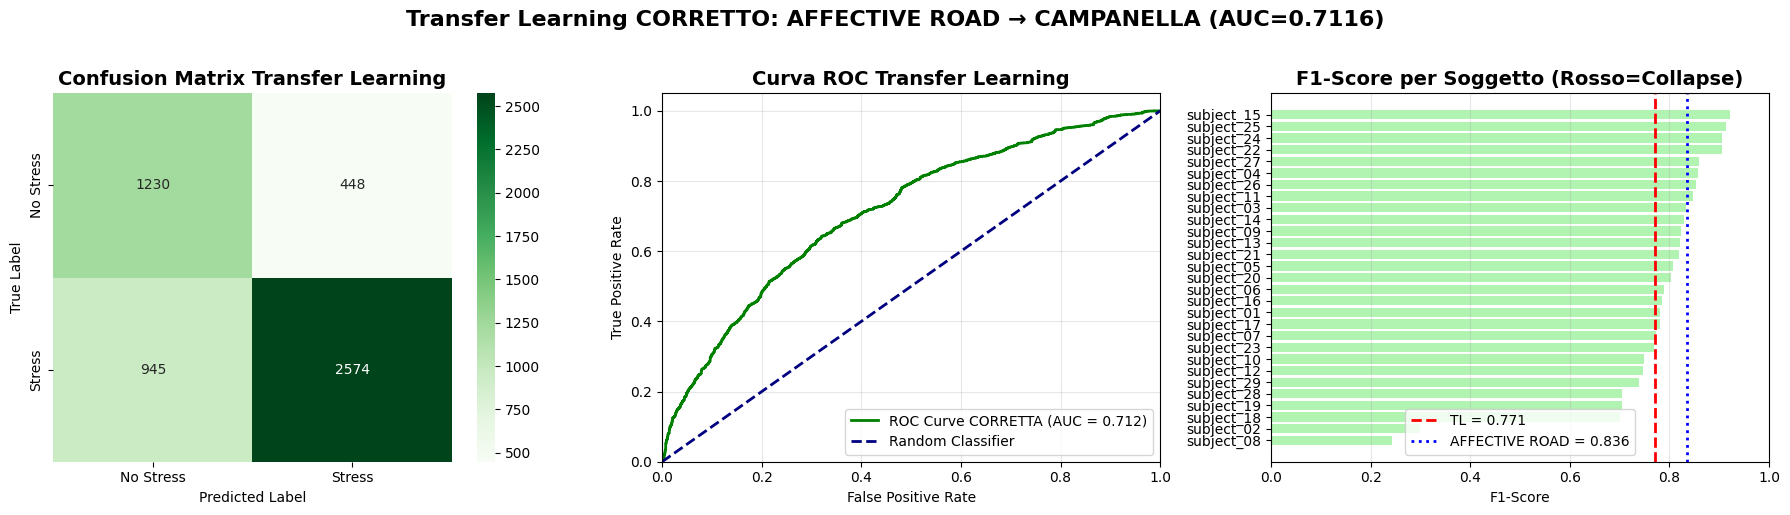


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/AFFECTIVEROAD_TO_CAMPANELLA_RESULTS_FIXED/affectiveroad_to_campanella_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/AFFECTIVEROAD_TO_CAMPANELLA_RESULTS_FIXED/affectiveroad_to_campanella_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: AFFECTIVE ROAD → CAMPANELLA CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV AFFECTIVE ROAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV AFFECTIVE ROAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="AFFECTIVE ROAD"):
    """Carica modello sorgente AFFECTIVE ROAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello AFFECTIVE ROAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON AFFECTIVE ROAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello AFFECTIVE ROAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers AFFECTIVE ROAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "AFFECTIVE ROAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: AFFECTIVE ROAD → CAMPANELLA")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (CAMPANELLA)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/AFFECTIVEROAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER AFFECTIVE ROAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER AFFECTIVE ROAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler AFFECTIVE ROAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"AFFECTIVE ROAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: AFFECTIVE ROAD → CAMPANELLA (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/CAMPANELLA/AFFECTIVEROAD_TO_CAMPANELLA_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "affectiveroad_to_campanella_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'CAMPANELLA',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_campanella_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")